# Pitchfork Reviews Analysis

In this project, I will analyse the data from the pitchfork reviews. The data comes from the Dataset: 

It is described as: "Pitchfork is a music-centric online magazine. It was started in 1995 and grew out of independent music reviewing into a general publication format, but is still famed for its variety music reviews. This dataset is provided as a sqlite database with the following tables: artists, content, genres, labels, reviews, years."

Here is a link to the dataset: [link] (https://www.kaggle.com/datasets/nolanbconaway/pitchfork-data)

There are three questions in the dataset that I will try to answer: 
1) Do review scores for individual artists generally improve over time, or go down?
2) Who are the most highly rated artists? The least highly rated artists?
3) How has Pitchfork's review genre selection changed over time?


In [4]:
import sqlite3
import pandas as pd 

#Connecting to the SQLite Database
conn = sqlite3.connect('database.sqlite')

#Exploring the data in the dataset by reading and visualising the data
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type = 'table';", conn)
print(tables)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
      name
0  reviews
1  artists
2   genres
3   labels
4    years
5  content


In [6]:
#Creating a list of tables
table_names = tables['name'].tolist()

#Printing the first 5 lines in each table
for table_name in table_names: 
    print(f'Table Name: {table_name}')
    df_tables = pd.read_sql_query(f'SELECT * FROM {table_name} LIMIT 5;', conn)
    print('-----------------------------------------------')
    print(df_tables)

Table Name: reviews
-----------------------------------------------
   reviewid                 title            artist  \
0     22703             mezzanine    massive attack   
1     22721          prelapsarian          krallice   
2     22659  all of them naturals      uranium club   
3     22661           first songs  kleenex, liliput   
4     22725             new start              taso   

                                                 url  score  best_new_music  \
0  http://pitchfork.com/reviews/albums/22703-mezz...    9.3               0   
1  http://pitchfork.com/reviews/albums/22721-prel...    7.9               0   
2  http://pitchfork.com/reviews/albums/22659-all-...    7.3               0   
3  http://pitchfork.com/reviews/albums/22661-firs...    9.0               1   
4  http://pitchfork.com/reviews/albums/22725-new-...    8.1               0   

           author               author_type    pub_date  pub_weekday  pub_day  \
0     nate patrin               contributor  

In [8]:
#Collecting review ids from each table
review_ids = {}

for table_name in table_names:
    review_ids[table_name] = pd.read_sql_query(f'SELECT reviewid FROM {table_name};', conn)['reviewid']

#Creating sets of reviewid values to compare with dictionary comprehension
review_id_sets = {table_name: set(ids) for table_name, ids in review_ids.items()}

#Finding the intersection of all review id sets
common_review_ids = set.intersection(*review_id_sets.values())

#Printing the number of common review ids accross all the tables in the dataframe
print(f'Number of common reviewid values accross all tables: {len(common_review_ids)}')


Number of common reviewid values accross all tables: 18389


In [9]:
#Making a list of all table names
table_names = ['reviews', 'artists', 'genres', 'labels', 'years', 'content']

#Getting the data from all the tables in the sqlite database
df_all_tables = []
for table_name in table_names: 
    query = f'SELECT * FROM {table_name} WHERE reviewid IN (SELECT reviewid FROM reviews);'
    df = pd.read_sql_query(query, conn)
    df_all_tables.append(df) #Appending each dataframe to the list of dataframes

#Closing the connection
conn.close()

#Now we have a list of dataframes and we want to merge them all in one single dataframe
df_merged = df_all_tables[0]
for df in df_all_tables[1:]: 
    df_merged = pd.merge(df_merged, df, on = 'reviewid', how = 'inner')

print(df_merged.head())


   reviewid                 title          artist_x  \
0     22703             mezzanine    massive attack   
1     22721          prelapsarian          krallice   
2     22659  all of them naturals      uranium club   
3     22659  all of them naturals      uranium club   
4     22661           first songs  kleenex, liliput   

                                                 url  score  best_new_music  \
0  http://pitchfork.com/reviews/albums/22703-mezz...    9.3               0   
1  http://pitchfork.com/reviews/albums/22721-prel...    7.9               0   
2  http://pitchfork.com/reviews/albums/22659-all-...    7.3               0   
3  http://pitchfork.com/reviews/albums/22659-all-...    7.3               0   
4  http://pitchfork.com/reviews/albums/22661-firs...    9.0               1   

           author               author_type    pub_date  pub_weekday  pub_day  \
0     nate patrin               contributor  2017-01-08            6        8   
1        zoe camp               

In [11]:
# Check for NaN values in each column
nan_counts = df_merged.isna().sum()
print(nan_counts)

reviewid             0
title                0
artist_x             0
url                  0
score                0
best_new_music       0
author               0
author_type       5962
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
artist_y             0
genre             2814
label               45
year               611
content              0
dtype: int64


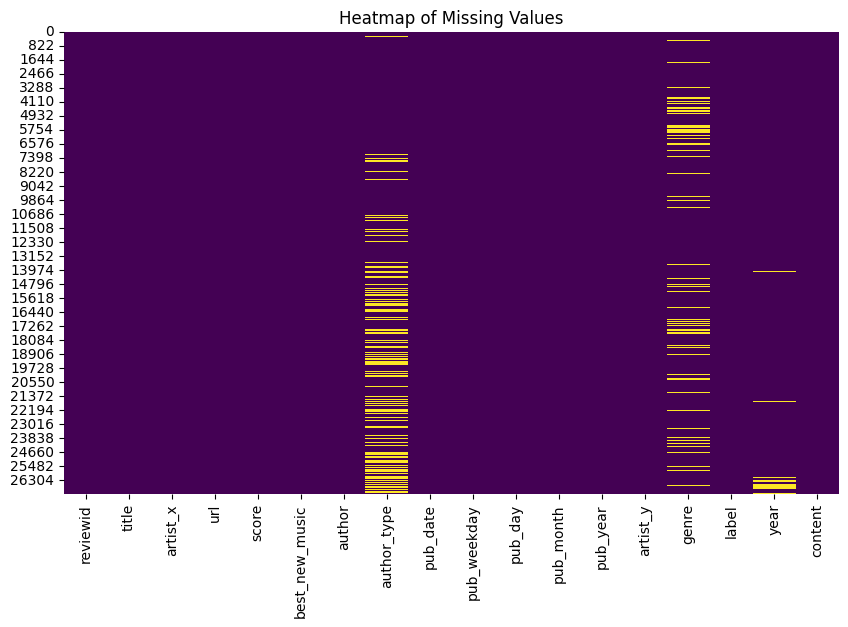

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize missing data using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_merged.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

## Do reviews Do review scores for individual artists generally improve over time, or go down?

To answer this question, I need to divide the data into artist groups and analyse them in different years. I don't need the author type, the genre or the lable. 

Now there is a question: Which year is the year when the review was publishes? The description of the dataset says nothing about what the columns contain so we must guess from the naming and the content. 

It may be pub_year (the year of publication  of either the album and the song) or the year (the year of publication of the song or the review). At first glance it makes sence to think that pub_year is the year of publication of the review since it is so correctly specified and there are no data omissions there. If you are scraping data from a website, you can see when the comments were published by the exact data. 

This means that Year would be the year of release of the song. However, when we take a look at the first 5 rows, I see that the Year is actually bigger than the Pub Year. So Pub Year should be the year of release of the song and Year should be the year of the review as it makes no sense to have a review published before the release of the song. 

So I will work with the year column. 

I will drop the rows with missing years since making an attempt to fill them with some data makes no sense. These are different observations and the mean or median year or the K-nearest neighbor don't make sense since the year of the song is not influenced by any of the other variable nor is by the other years of the artist. 

We will lose about 3% of the observations of the dataset but we sufficient datapoints to work with. I want to see that my year column and score column are of numeric type.


In [15]:
print(df_merged.dtypes)

reviewid            int64
title              object
artist_x           object
url                object
score             float64
best_new_music      int64
author             object
author_type        object
pub_date           object
pub_weekday         int64
pub_day             int64
pub_month           int64
pub_year            int64
artist_y           object
genre              object
label              object
year              float64
content            object
dtype: object


In [17]:
#Dropping the rows with missing years
df_clean_year = df_merged.dropna(subset = ['year'])

#Verifying that there are no NaN years
nan_counts = df_clean_year.isna().sum()
print(nan_counts)

reviewid             0
title                0
artist_x             0
url                  0
score                0
best_new_music       0
author               0
author_type       5604
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
artist_y             0
genre             2771
label               45
year                 0
content              0
dtype: int64


In [53]:
#Grouping the data by artist and sort the reviews by date (in two steps)
#Step 1: Filter out artists with less than 5 reviews
filtered_df = df_clean_year.groupby('artist_x').filter(lambda x: len(x) > 5)

#Step 2: Sort the filtered DataFrame by artist and year
sorted_df = filtered_df.sort_values(['artist_x', 'year']).reset_index(drop=True)


In [54]:
#The list of unique artists
unique_artists = filtered_df['artist_x'].unique()
print(f'Number of unique artists: {len(unique_artists)}')
print(unique_artists)

Number of unique artists: 1145
['massive attack' 'krallice' 'various artists' ... 'dj spooky, scanner'
 'john cale, tony conrad, angus maclise, la monte young, marian zazeela'
 'tortoise, the ex']


In [58]:
#Function to calculate the trend for each artist
def calculate_score_trend(artist_df): #A function names calculate_score_trend that takes one parameter
    avg_score_per_year = artist_df.groupby('year')['score'].mean().reset_index()#`finding the mean of all scores from each year of each artist
    if len(avg_score_per_year) > 1: #Check if the artist has reviews for more than one year, if it has only reviews in one year, we can't calculate the differences
        return avg_score_per_year['score'].diff().mean() #Calculates the differences between consequtive years and finding and making a series out of it. Then calculating the mean of all these differences. 
    else:
        return None #The case in which it has only one years of reviews. 

#Appling the function to each artist group
score_trends = sorted_df.groupby('artist_x', group_keys=False).apply(calculate_score_trend).reset_index(name='score_trend')

# Drop NaN values (which represent artists with only one year of reviews after filtering)
score_trends = score_trends.dropna()

/var/folders/s8/8q4nspg501l5dtl_1yw_prmr0000gn/T/ipykernel_71793/2723348283.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  score_trends = sorted_df.groupby('artist_x', group_keys=False).apply(calculate_score_trend).reset_index(name='score_trend')


In [59]:
#Selecting 16 random artists
random_artists = score_trends.dropna().sample(n=16, random_state=1)

#Printing trends for the selected artists
for index, row in random_artists.iterrows():
    trend = 'increasing' if row['score_trend'] > 0 else 'declining'
    print(f"Artist: {row['artist_x']}: Review scores are {trend} over time.")

Artist: david lynch: Review scores are declining over time.
Artist: pauline oliveros: Review scores are declining over time.
Artist: sloan: Review scores are declining over time.
Artist: suede: Review scores are increasing over time.
Artist: nurse with wound: Review scores are declining over time.
Artist: hard-fi: Review scores are declining over time.
Artist: mark stewart: Review scores are declining over time.
Artist: sparta: Review scores are declining over time.
Artist: maximo park: Review scores are declining over time.
Artist: bill callahan: Review scores are increasing over time.
Artist: cluster: Review scores are declining over time.
Artist: patti smith: Review scores are declining over time.
Artist: arctic monkeys: Review scores are increasing over time.
Artist: morrissey: Review scores are declining over time.
Artist: dungen: Review scores are increasing over time.
Artist: rufus wainwright: Review scores are declining over time.


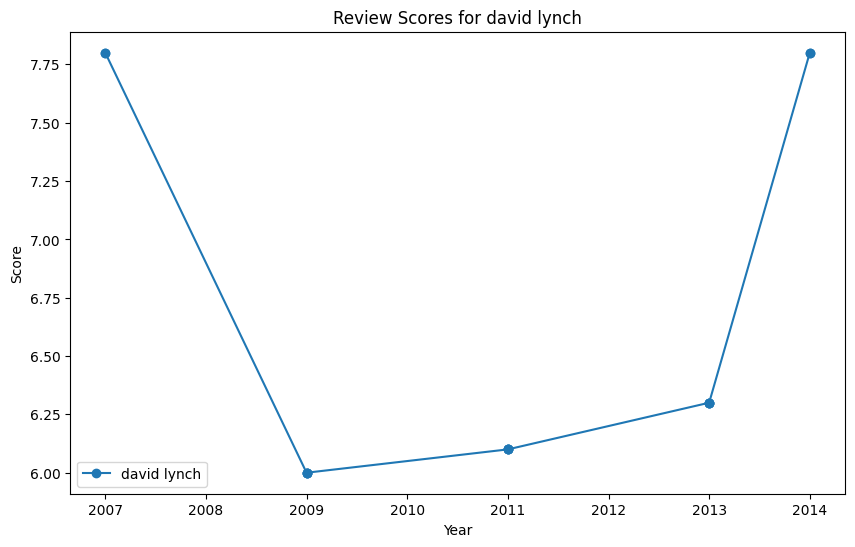

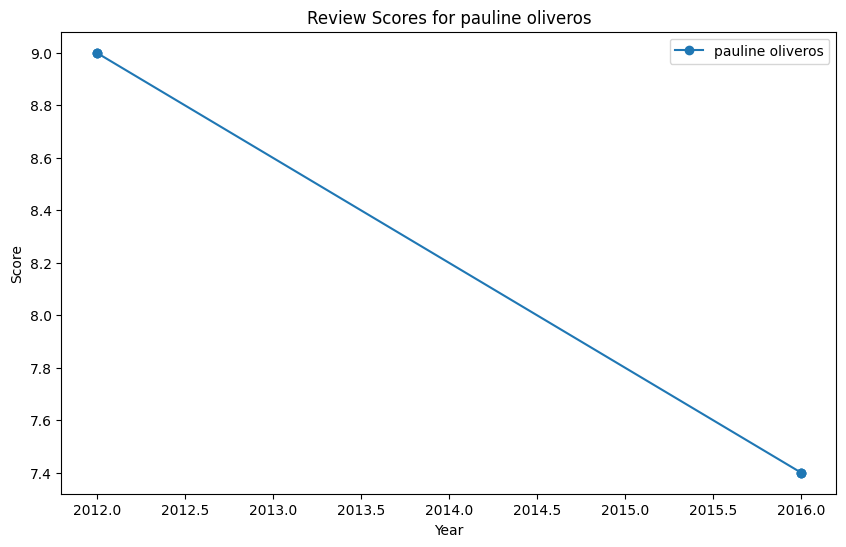

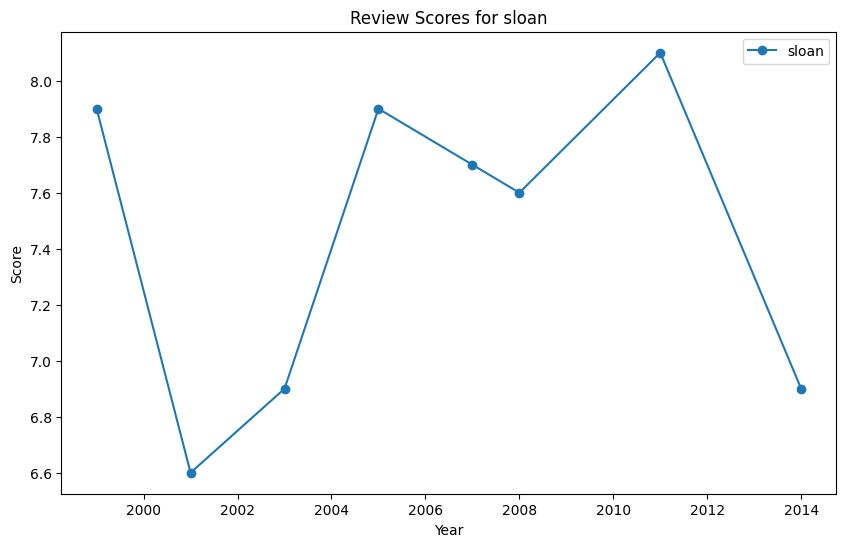

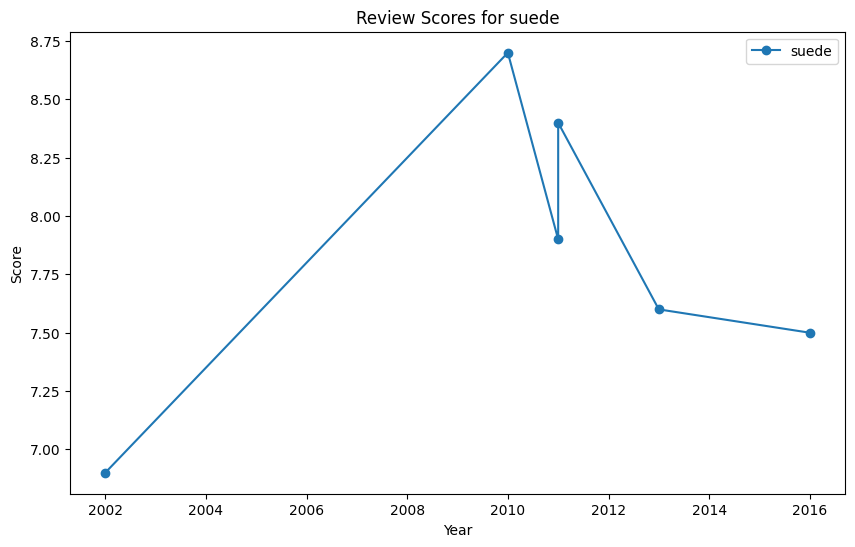

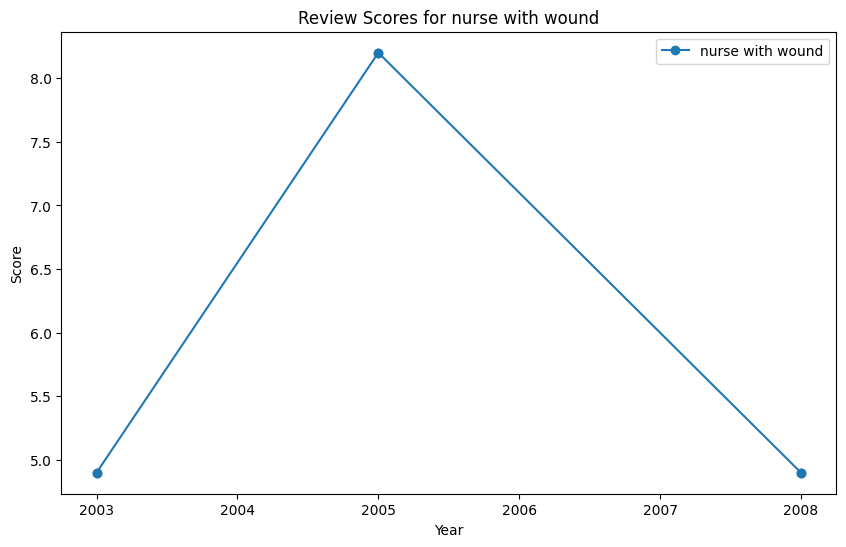

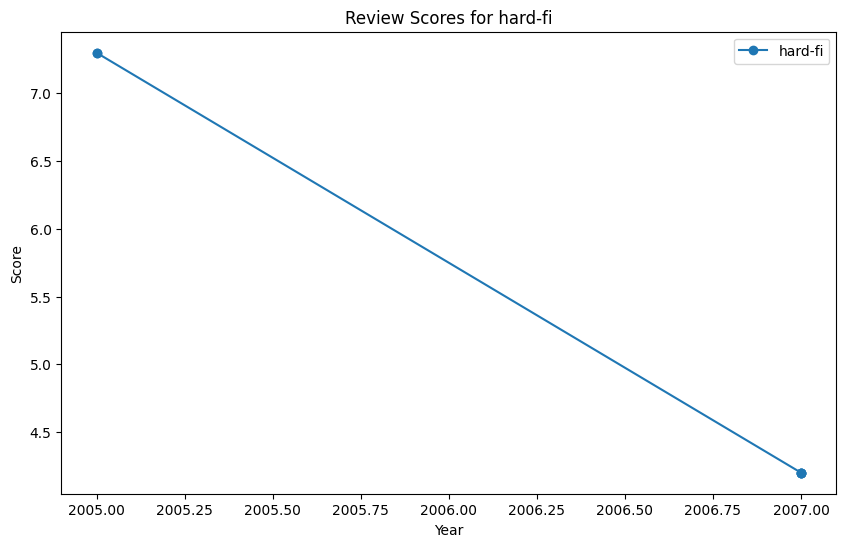

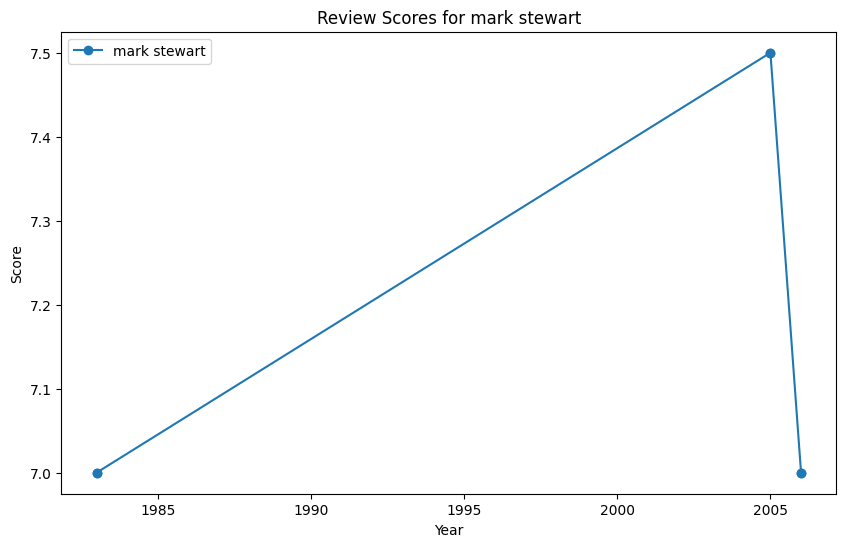

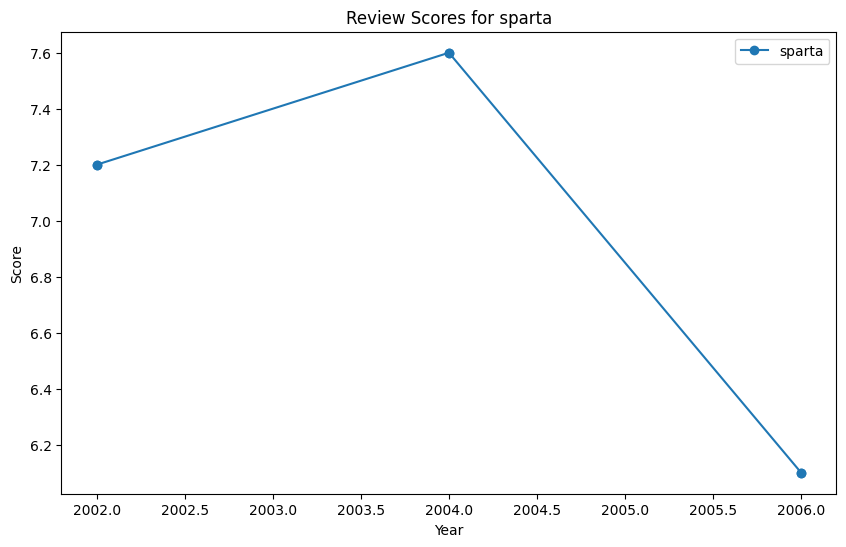

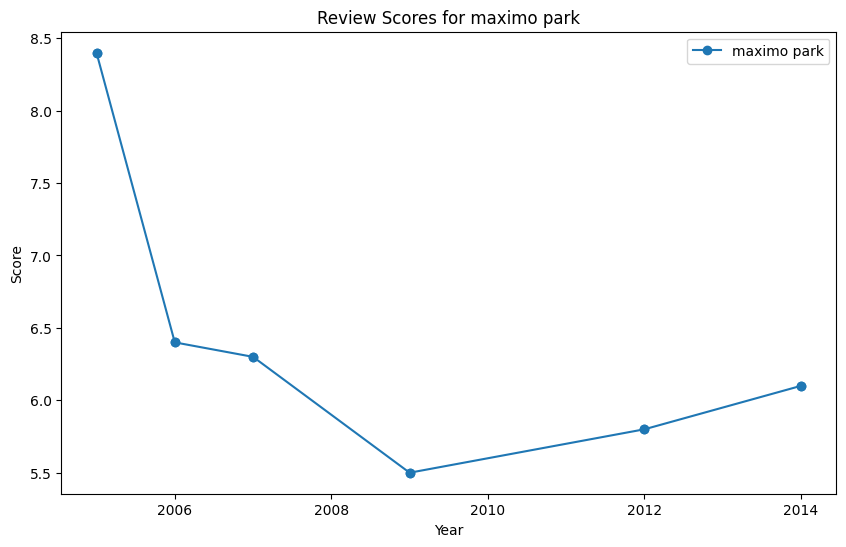

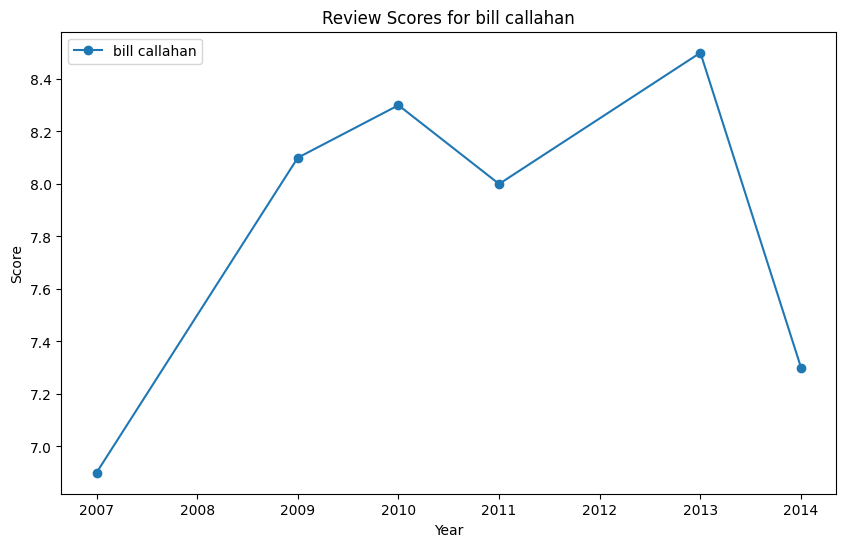

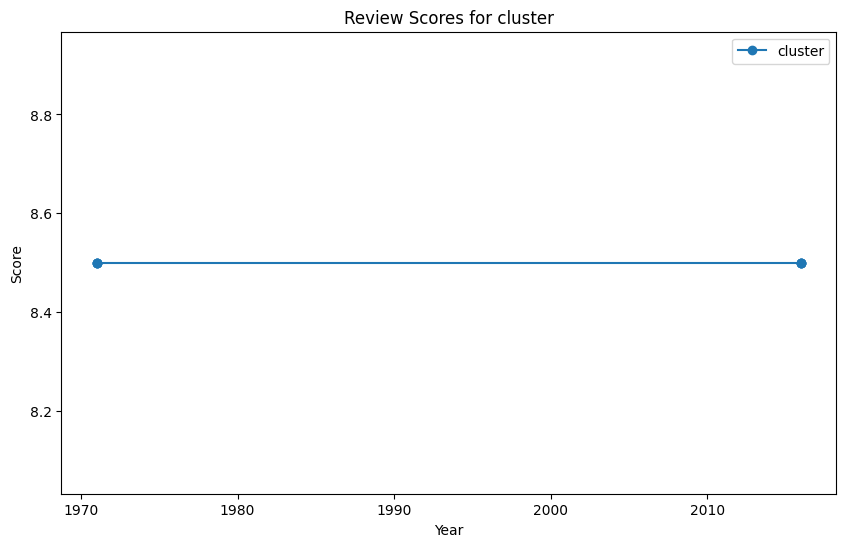

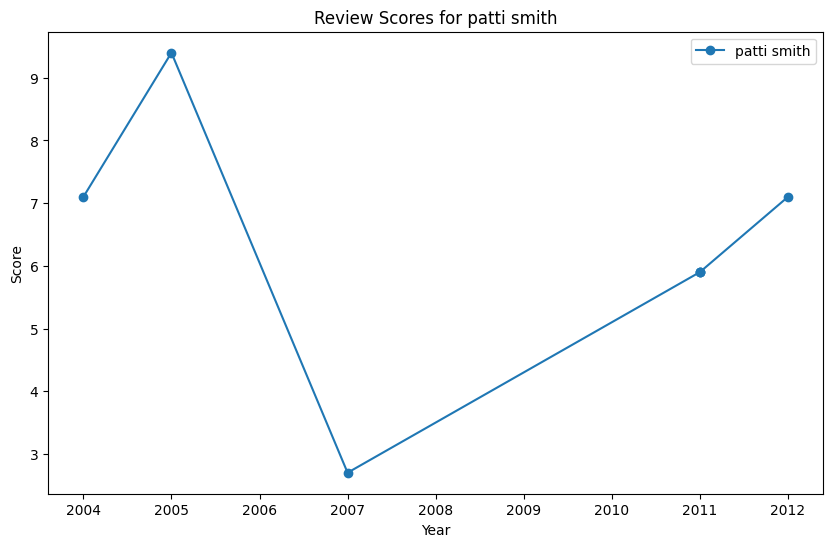

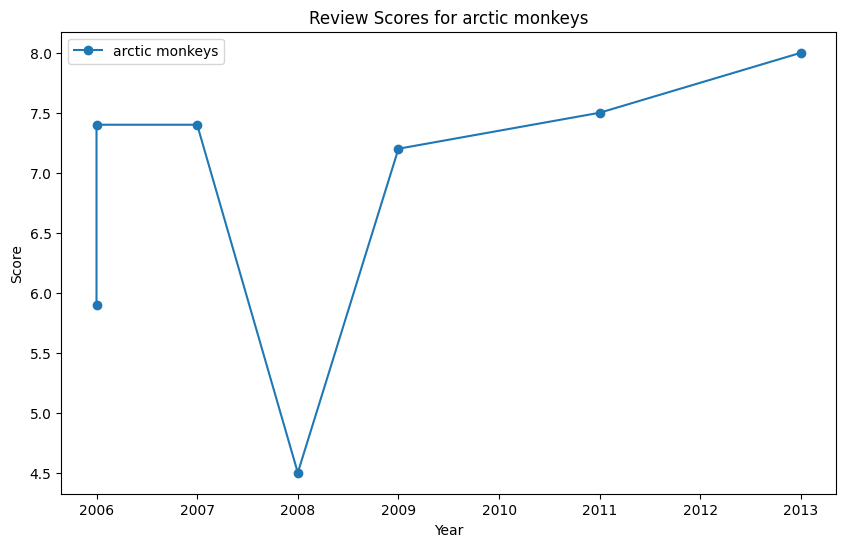

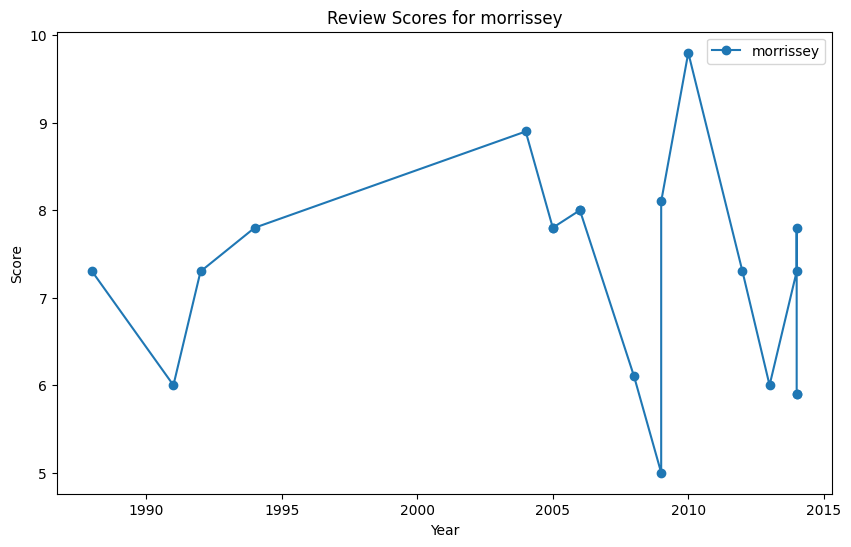

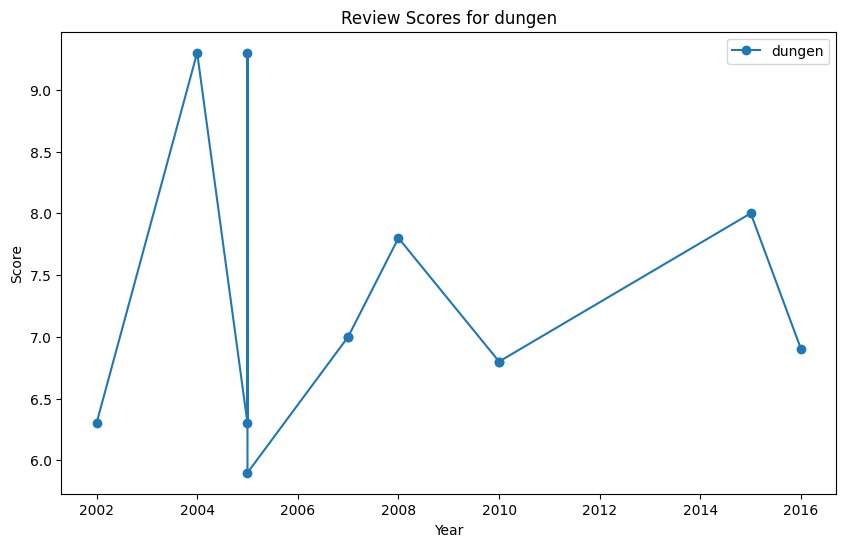

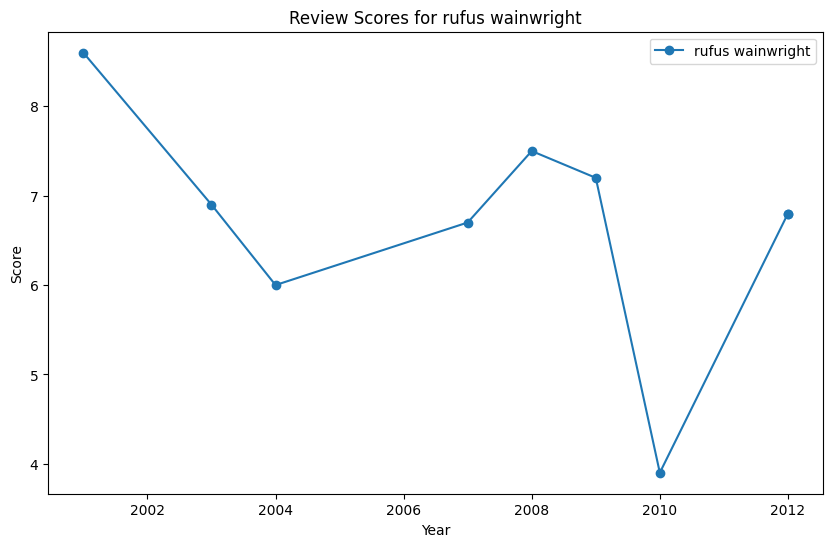

In [60]:
import matplotlib.pyplot as plt

#Visualizing all the mean scores per year for each artist in the selected group
for artist in random_artists['artist_x']:
    artist_reviews = grouped_artists[grouped_artists['artist_x'] == artist]
    plt.figure(figsize=(10, 6))
    plt.plot(artist_reviews['year'], artist_reviews['score'], marker='o', label=artist)
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.title(f'Review Scores for {artist}')
    plt.legend()
    plt.show()

In [61]:
# Determine overall trend
overall_trend = score_trends['score_trend'].mean()
print(f"Overall trend in review scores: {'improving' if overall_trend > 0 else 'declining'}")


Overall trend in review scores: declining


## Who are the most highly rated and the least highly rated artists? 

I can answer this question by two different approaches. 

Approach 1: Calculate the mean score for all artist groups and see who has the highest and the lowest score. this will give me the highest and the lowest performer in absolute terms. 
Approach 2: I can say do a regression analysis and see which artistis are furthest away from the regression line. This will give me relative information who performs the best or the worst compared to the average expectation of the whole group of artists. 

I will do both. 

### Approach 1: Absolute best and worst performenrs

In [62]:
#Calculating the average score for each artist
average_scores = df_clean_year.groupby('artist_x')['score'].mean().reset_index()
average_scores.columns = ['artist_x', 'avg_score']

#Identifying the most highly rated and least highly rated artists
highest_rated_artists = average_scores.sort_values(by='avg_score', ascending=False).head(10)
lowest_rated_artists = average_scores.sort_values(by='avg_score', ascending=True).head(10)

print("Most Highly Rated Artists:")
print(highest_rated_artists)

print("\nLeast Highly Rated Artists:")
print(lowest_rated_artists)

Most Highly Rated Artists:
                              artist_x  avg_score
1654                           dangelo      10.00
6769                     stevie wonder      10.00
6926                         talk talk      10.00
6984                        television      10.00
6544                             slint      10.00
7638                   the stone roses      10.00
2262  elvis costello & the attractions       9.75
5056               my bloody valentine       9.70
5078                            n.w.a.       9.70
8055                ultramagnetic mc's       9.70

Least Highly Rated Artists:
                          artist_x  avg_score
7940               travis morrison        0.0
5830                    push kings        0.1
1646  dan le sac vs. scroobius pip        0.2
6392                          shat        0.2
4201                 liars academy        0.6
4338           lou reed, metallica        1.0
537         avey tare, kra brekkan        1.0
5251                      

### Approach 2: Relative best and worst artists

Artist with highest score compared to expected: talk talk
Artist with highest score compared to expected: travis morrison


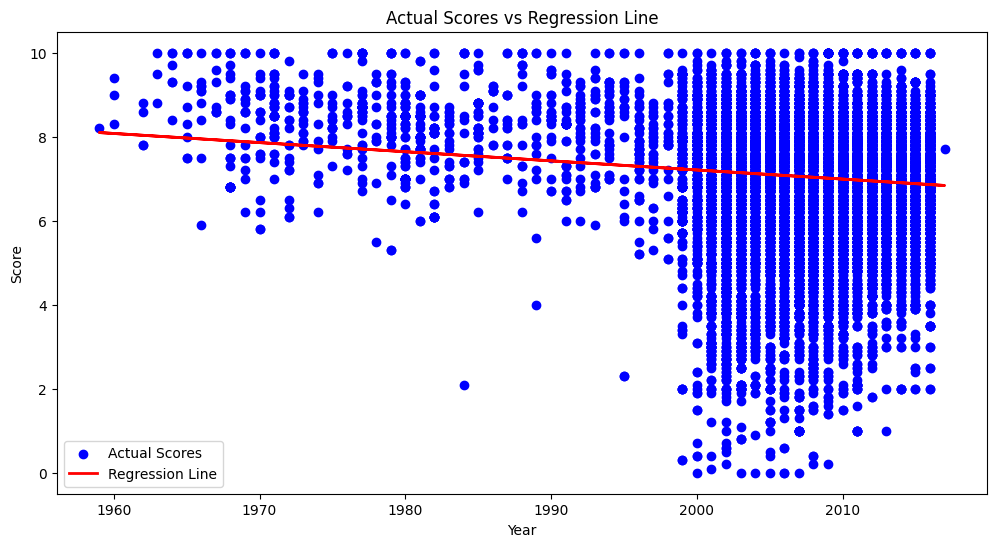

In [66]:
import numpy as np
from sklearn.linear_model import LinearRegression

#Performing Linear Regression
X = df_clean_year[['year']]  # Use 'year' as the independent variable
y = df_clean_year['score']   # Use 'score' as the dependent variable

model = LinearRegression()
model.fit(X, y)

#Calculating Residuals
df_clean_year = df_clean_year.copy() #Avoiding a warning message when working with the dataframe. 
df_clean_year['predicted_score'] = model.predict(X)
df_clean_year['residuals'] = df_clean_year['score'] - df_clean_year['predicted_score']

#Identifying Artists with Highest Residuals (positive residuals mean above the expected score)
average_residuals = df_clean_year.groupby('artist_x')['residuals'].mean().reset_index()
average_residuals.columns = ['artist_x', 'avg_residual']

#Finding the artist with the highest positive residual (most above expected score)
most_above_expectation = average_residuals.sort_values(by='avg_residual', ascending=False).head(1)
lowest_below_expectation = average_residuals.sort_values(by='avg_residual', ascending=True).head(1)

#Displaying the artist with the highest positive residual
print(f"Artist with highest score compared to expected: {most_above_expectation['artist_x'].iloc[0]}")
print(f"Artist with highest score compared to expected: {lowest_below_expectation['artist_x'].iloc[0]}")

# Optionally, visualize residuals for all artists
plt.figure(figsize=(12, 6))
plt.scatter(df_clean_year['year'], df_clean_year['score'], color='blue', label='Actual Scores')
plt.plot(df_clean_year['year'], df_clean_year['predicted_score'], color='red', linewidth=2, label='Regression Line')
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Actual Scores vs Regression Line')
plt.legend()
plt.show()

In [68]:
#Filtering the rows where artist is 'Travis Morrison'
travis_morrison_rows = df_clean_year[df_clean_year['artist_x'] == 'travis morrison']

print(travis_morrison_rows)

       reviewid      title         artist_x  \
21336      5607  travistan  travis morrison   

                                                     url  score  \
21336  http://pitchfork.com/reviews/albums/5607-travi...    0.0   

       best_new_music        author author_type    pub_date  pub_weekday  \
21336               0  chris dahlen        None  2004-09-27            0   

       pub_day  pub_month  pub_year         artist_y    genre   label    year  \
21336       27          9      2004  travis morrison  pop/r&b  barsuk  2004.0   

                                                 content  predicted_score  \
21336  Travis Morrison got his ass kicked.  He tells ...         7.121639   

       residuals  
21336  -7.121639  


It seems that there is no mistake and Travis Morrison indeed has some content in his review. So he is the worst performer in terms of scores from these reviews. 

## How has Pitchfork's review genre selection changed over time?

To answer this question, I will first need to clean all the rows with missing genre from my clean year dataframe. 

In [69]:
df_clean = df_clean_year.dropna(subset=['genre'])

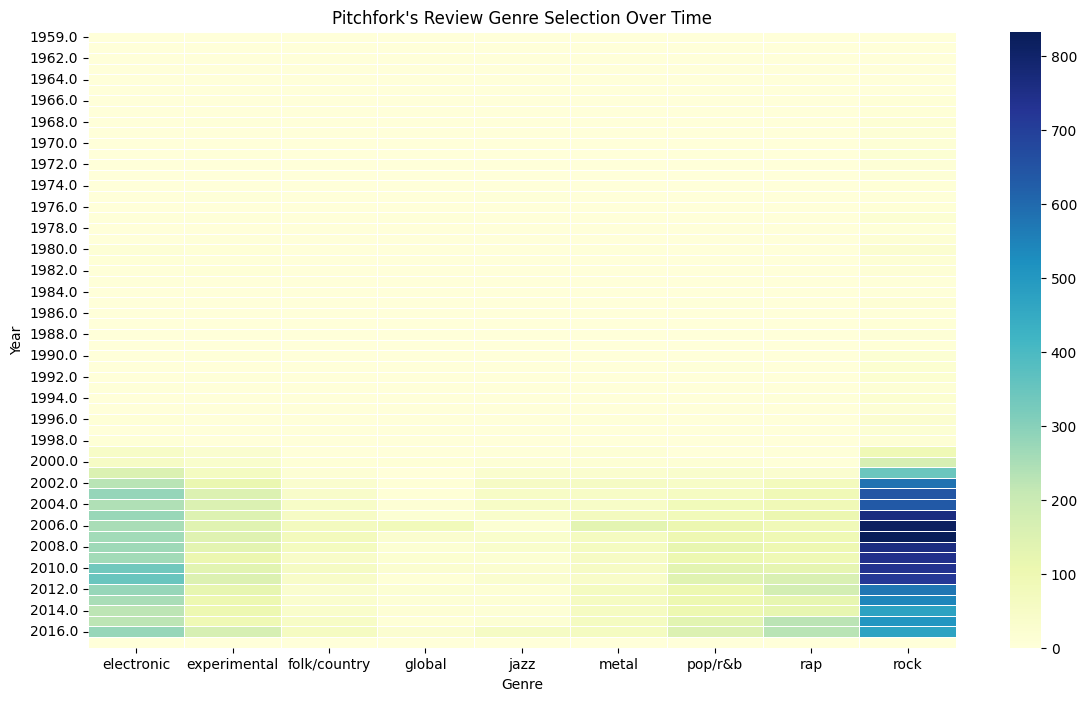

In [70]:
import seaborn as sns

#Grouping by year and genre and then counting the reviews in each group
genre_counts = df_clean.groupby(['year', 'genre']).size().reset_index(name='count')

#Creating a pivot table to reshape the data for visualization. 
#Using pd.pivot_table() to reshape the data so that 
#years are rows, genres are columns and the values are counts of reviews
pivot_table = genre_counts.pivot(index='year', columns='genre', values='count').fillna(0)

# Plotting the data using seaborn heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5)
plt.title("Pitchfork's Review Genre Selection Over Time")
plt.xlabel('Genre')
plt.ylabel('Year')
plt.show()